<a href="https://colab.research.google.com/github/saitharun5515/Dissertation-Early-Detection-of-Alzheimer-s-Disease-/blob/main/Alzheimers_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
dataset = load_dataset("Falah/Alzheimer_MRI")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-c08a401c53fe53(…):   0%|          | 0.00/22.6M [00:00<?, ?B/s]

data/test-00000-of-00001-44110b9df98c558(…):   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})

In [4]:
label_names = {
    0: "MildDemented",
    1: "ModerateDemented",
    2: "NonDemented",
    3: "VeryMildDemented"
}

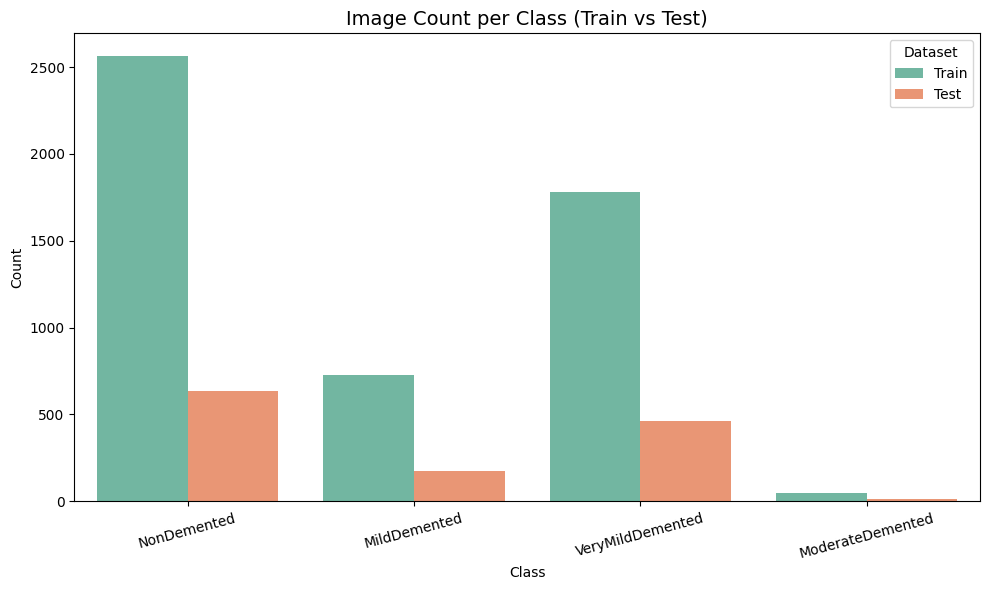

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

train_counts = Counter(dataset['train']['label'])
test_counts = Counter(dataset['test']['label'])


df_train = pd.DataFrame({'Class': [label_names[i] for i in train_counts.keys()],
                         'Count': train_counts.values(),
                         'Dataset': 'Train'})

df_test = pd.DataFrame({'Class': [label_names[i] for i in test_counts.keys()],
                        'Count': test_counts.values(),
                        'Dataset': 'Test'})

df_all = pd.concat([df_train, df_test])

plt.figure(figsize=(10,6))
sns.barplot(x='Class', y='Count', hue='Dataset', data=df_all, palette='Set2')
plt.title("Image Count per Class (Train vs Test)", fontsize=14)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

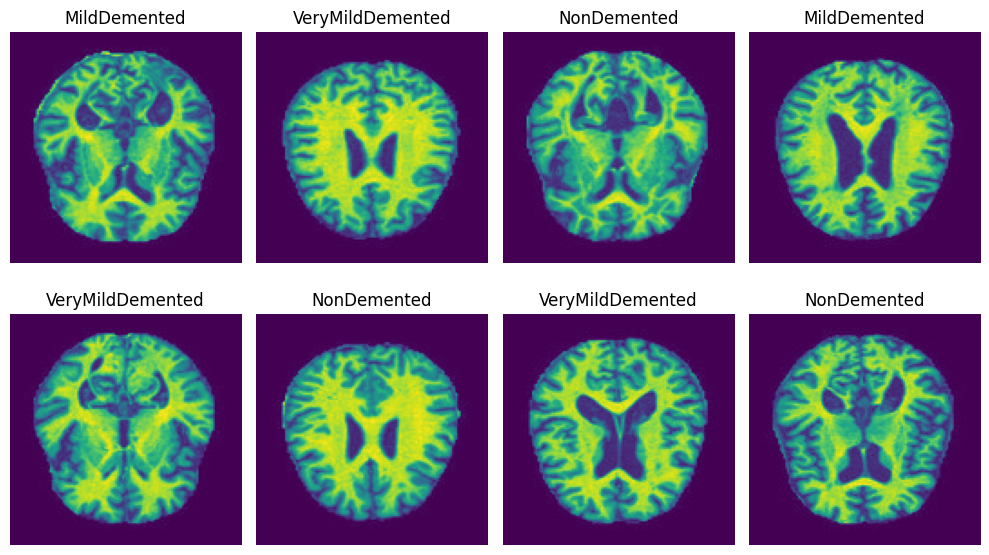

In [6]:
import random

plt.figure(figsize=(10,6))
for i in range(8):
    sample = random.choice(dataset['train'])
    img = sample['image']
    label = label_names[sample['label']]
    plt.subplot(2,4,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
train_valid_split = dataset['train'].train_test_split(test_size=0.10, seed=42)
train_hf = train_valid_split['train']
val_hf   = train_valid_split['test']
test_hf  = dataset['test']

print("HF sizes -> train:", len(train_hf), "val:", len(val_hf), "test:", len(test_hf))

print("Train counts:", Counter(train_hf['label']))
print("Val counts:  ", Counter(val_hf['label']))
print("Test counts: ", Counter(test_hf['label']))

HF sizes -> train: 4608 val: 512 test: 1280
Train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Val counts:   Counter({2: 253, 3: 169, 0: 80, 1: 10})
Test counts:  Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [8]:
from torch.utils.data import Dataset

class HFDatasetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image']

        if hasattr(img, "mode"):
            if img.mode != "RGB":
                img = img.convert("RGB")
        else:

            from PIL import Image
            img = Image.fromarray(img).convert("RGB")

        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
from datasets import load_dataset
import numpy as np
from PIL import Image
import random
from collections import Counter
import time
import copy

In [10]:
import torchvision.transforms as T

IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_test_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [11]:
BATCH_SIZE = 32
num_workers = 2
train_ds = HFDatasetTorch(train_hf, transform=train_transforms)
val_ds   = HFDatasetTorch(val_hf, transform=val_test_transforms)
test_ds  = HFDatasetTorch(test_hf, transform=val_test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [12]:
batch = next(iter(train_loader))
imgs, labels = batch
print("Images shape:", imgs.shape)
print("Labels shape:", labels.shape)

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [13]:
# ResNet18 transfer learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(label_names)

model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for epoch in range(num_epochs):
        since = time.time()
        print(f"Epoch {epoch+1}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total
            print(f"  {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")


            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch time: {time.time()-since:.1f}s\n")

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history

In [15]:
NUM_EPOCHS = 5
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

torch.save(model.state_dict(), "best_resnet18_alzheimers.pth")
print("Saved best_resnet18_alzheimers.pth")

Epoch 1/5
  train Loss: 0.8540 Acc: 0.6213
  val Loss: 0.7672 Acc: 0.6660
Epoch time: 23.3s

Epoch 2/5
  train Loss: 0.6214 Acc: 0.7378
  val Loss: 0.5774 Acc: 0.7559
Epoch time: 19.9s

Epoch 3/5
  train Loss: 0.4414 Acc: 0.8197
  val Loss: 0.4192 Acc: 0.8379
Epoch time: 21.3s

Epoch 4/5
  train Loss: 0.3094 Acc: 0.8824
  val Loss: 0.2621 Acc: 0.9043
Epoch time: 21.9s

Epoch 5/5
  train Loss: 0.2194 Acc: 0.9208
  val Loss: 0.3320 Acc: 0.8730
Epoch time: 20.3s

Best val Acc: 0.9043
Saved best_resnet18_alzheimers.pth


In [16]:
def evaluate(model, loader):
    model.eval()
    running_corrects = 0
    total = 0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())
    acc = running_corrects / total
    return acc, preds_all, labels_all

test_acc, preds, labels = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8898


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(labels, preds, target_names=[label_names[i] for i in range(num_classes)]))

Confusion matrix:
 [[135   0   5  32]
 [  0  13   0   2]
 [ 10   0 598  26]
 [  7   0  59 393]]
Classification report:
                   precision    recall  f1-score   support

    MildDemented       0.89      0.78      0.83       172
ModerateDemented       1.00      0.87      0.93        15
     NonDemented       0.90      0.94      0.92       634
VeryMildDemented       0.87      0.86      0.86       459

        accuracy                           0.89      1280
       macro avg       0.91      0.86      0.89      1280
    weighted avg       0.89      0.89      0.89      1280



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import cv2
import os
import torch
import torchvision.transforms as T

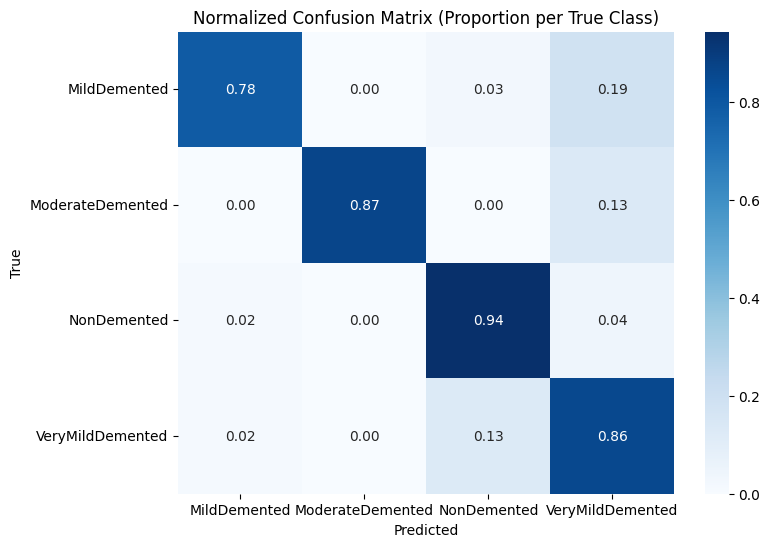

In [19]:
cm = confusion_matrix(labels, preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=[label_names[i] for i in range(len(label_names))],
            yticklabels=[label_names[i] for i in range(len(label_names))], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix (Proportion per True Class)')
plt.show()

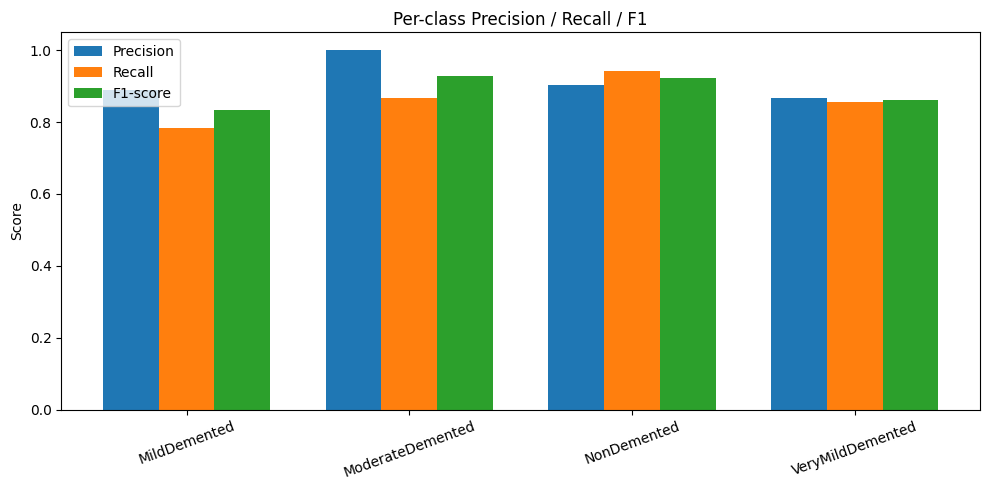

In [20]:
prec, rec, f1, sup = precision_recall_fscore_support(labels, preds, labels=list(range(len(label_names))))
classes = [label_names[i] for i in range(len(label_names))]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x, rec, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, classes, rotation=20)
plt.ylim(0,1.05)
plt.ylabel('Score')
plt.title('Per-class Precision / Recall / F1')
plt.legend()
plt.tight_layout()
plt.show()

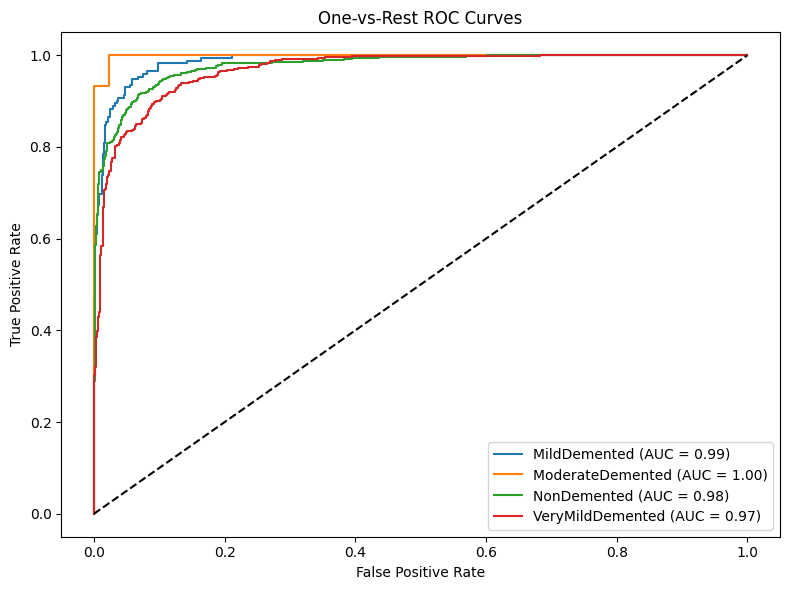

In [21]:
model.eval()
probs_all = []
labels_all = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        probs_all.append(probs)
        labels_all.extend(labs.numpy().tolist())
probs_all = np.vstack(probs_all)
y_true = np.array(labels_all)
n_classes = len(label_names)
y_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_names[i]} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


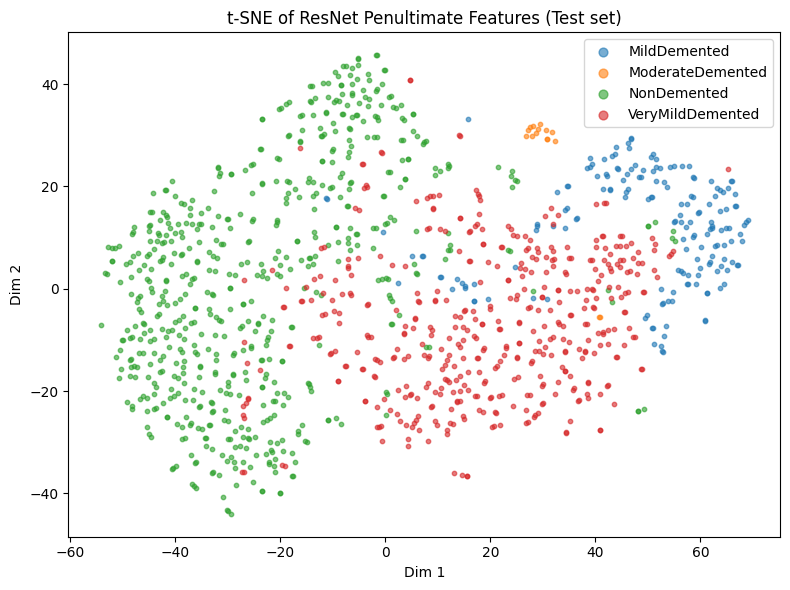

In [22]:
model.eval()
features = []
labels_feats = []
with torch.no_grad():
    for inputs, labs in test_loader:
        inputs = inputs.to(device)
        x = model.conv1(inputs)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        features.append(x.cpu().numpy())
        labels_feats.extend(labs.numpy().tolist())

features = np.vstack(features)
labels_feats = np.array(labels_feats)

sample_n = 2000
if features.shape[0] > sample_n:
    idx = np.random.choice(features.shape[0], sample_n, replace=False)
    feat_sample = features[idx]
    lab_sample = labels_feats[idx]
else:
    feat_sample = features
    lab_sample = labels_feats

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
emb = tsne.fit_transform(feat_sample)

plt.figure(figsize=(8,6))
for i, cname in enumerate([label_names[i] for i in range(n_classes)]):
    mask = lab_sample == i
    plt.scatter(emb[mask,0], emb[mask,1], label=cname, alpha=0.6, s=10)
plt.legend(markerscale=2)
plt.title('t-SNE of ResNet Penultimate Features (Test set)')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.tight_layout()
plt.show()

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as T

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None

        def save_grad(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        def save_activation(module, input, output):
            self.activations = output.detach()


        target_layer.register_forward_hook(save_activation)
        target_layer.register_full_backward_hook(save_grad)

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[0, class_idx]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0,2,3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]
        heatmap = torch.sum(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-8)
        return heatmap, class_idx

target_layer = model.layer4
gcam = GradCAM(model, target_layer)

print("Grad-CAM object created")

Grad-CAM object created


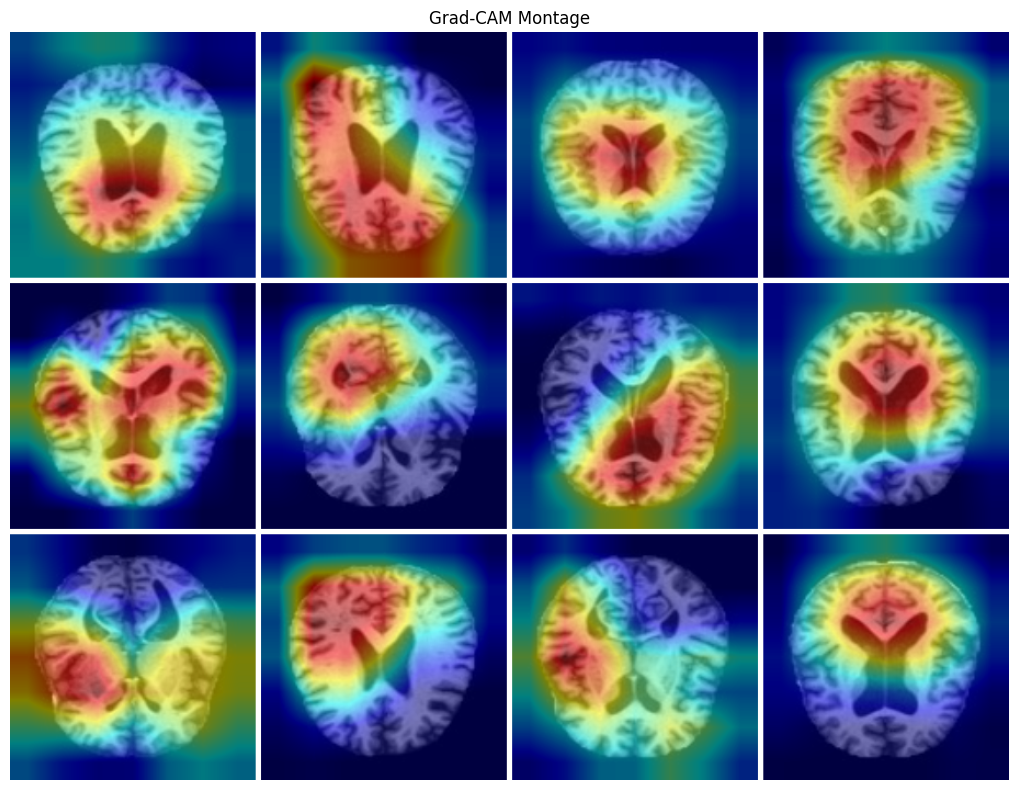

Saved: gradcam_montage/gradcam_montage.png


In [24]:
def generate_gradcam_overlay(inp_tensor, gcam):
    heatmap, pred_class = gcam(inp_tensor.to(device), None)
    inv_norm = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_norm(inp_tensor[0].cpu()).clamp(0,1)
    img_np = np.uint8(255 * img.permute(1,2,0).numpy())
    hmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    hmap_uint = np.uint8(255 * hmap)
    hmap_color = cv2.applyColorMap(hmap_uint, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(hmap_color, 0.5, img_np[..., ::-1], 0.5, 0)
    overlay = overlay[..., ::-1]
    return overlay, pred_class

import os
os.makedirs("gradcam_montage", exist_ok=True)

imgs_collected = []
titles = []
N = 12
count = 0
for inputs, labs in test_loader:
    for i in range(inputs.size(0)):
        inp = inputs[i].unsqueeze(0)
        overlay, pred = generate_gradcam_overlay(inp, gcam)
        imgs_collected.append(overlay)
        titles.append(f"T:{label_names[labs[i].item()]}|P:{label_names[pred]}")
        count += 1
        if count >= N:
            break
    if count >= N:
        break

rows, cols = 3, 4
h, w, _ = imgs_collected[0].shape
montage = np.ones((rows*h + (rows-1)*5, cols*w + (cols-1)*5, 3), dtype=np.uint8)*255
k = 0
for r in range(rows):
    for c in range(cols):
        if k >= len(imgs_collected): break
        r0, c0 = r*(h+5), c*(w+5)
        montage[r0:r0+h, c0:c0+w] = imgs_collected[k]
        k += 1

plt.figure(figsize=(12,8))
plt.imshow(montage)
plt.axis('off')
plt.title('Grad-CAM Montage')
plt.tight_layout()
plt.savefig("gradcam_montage/gradcam_montage.png", bbox_inches='tight')
plt.show()
print("Saved: gradcam_montage/gradcam_montage.png")

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image

class HFDatasetTorch(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item['image']
        # convert to PIL RGB if needed
        if hasattr(img, "mode"):
            if img.mode != "RGB":
                img = img.convert("RGB")
        else:
            img = Image.fromarray(img).convert("RGB")
        label = int(item['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [26]:
IMG_SIZE = 224

# -- Transforms for pretrained models (ImageNet normalization)
pretrained_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# -- Transforms for scratch models (simple normalization)
scratch_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
    # simple normalization centered at 0.5 (good default for scratch nets)
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

# -- Validation / test transforms (no augmentation)
pretrained_val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

scratch_val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [27]:
train_ds = HFDatasetTorch(train_hf, transform=scratch_transforms)
val_ds   = HFDatasetTorch(val_hf,   transform=scratch_val_transforms)
test_ds  = HFDatasetTorch(test_hf,  transform=scratch_val_transforms)

In [28]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [29]:
print("Dataset sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))
train_counts = Counter(train_hf['label'])
val_counts = Counter(val_hf['label'])
test_counts = Counter(test_hf['label'])
print("Train counts:", train_counts)
print("Val counts:  ", val_counts)
print("Test counts: ", test_counts)

Dataset sizes -> train: 4608 val: 512 test: 1280
Train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Val counts:   Counter({2: 253, 3: 169, 0: 80, 1: 10})
Test counts:  Counter({2: 634, 3: 459, 0: 172, 1: 15})


In [30]:
batch = next(iter(train_loader))
imgs, labels = batch
print("Batch images shape:", imgs.shape)
print("Batch labels shape:", labels.shape)
print("Label sample counts in batch:", Counter(labels.tolist()))

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])
Label sample counts in batch: Counter({0: 13, 3: 9, 2: 9, 1: 1})


In [31]:
def denormalize(img_tensor, mode='scratch'):
    img = img_tensor.clone()
    if mode == 'pretrained':
        mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
        std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
        img = img * std + mean
    else:
        mean = torch.tensor([0.5,0.5,0.5]).view(3,1,1)
        std = torch.tensor([0.5,0.5,0.5]).view(3,1,1)
        img = img * std + mean
    img = img.clamp(0,1)
    npimg = img.permute(1,2,0).cpu().numpy()
    return npimg

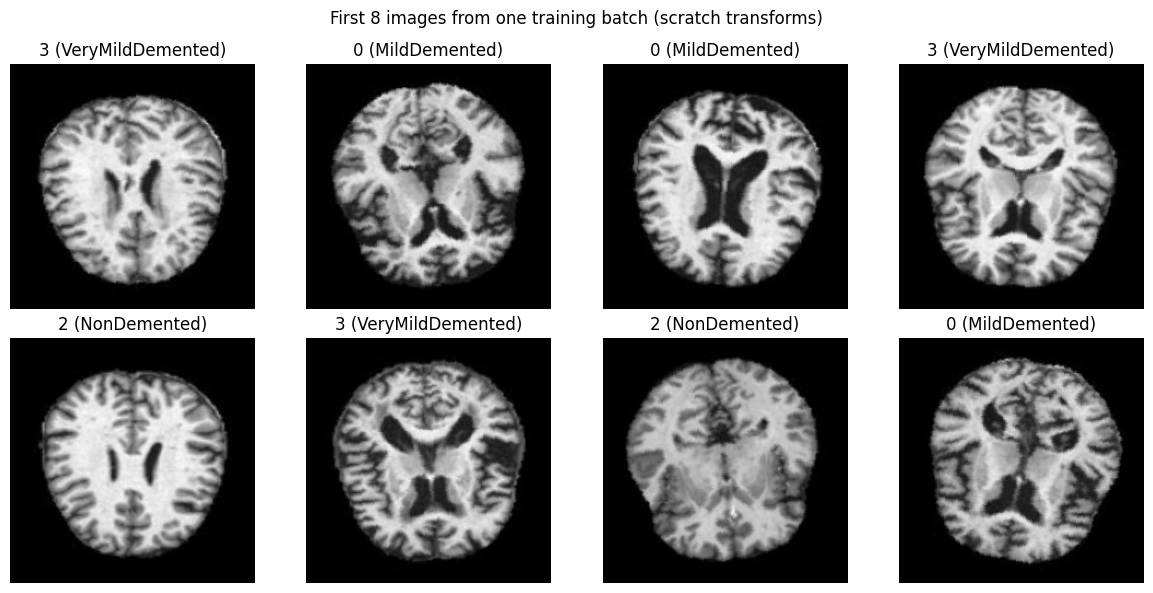

STEP 1 complete. Paste the printed output and confirm the images displayed correctly.


In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(denormalize(imgs[i], mode='scratch'))
    plt.title(f"{labels[i].item()} ({label_names[labels[i].item()]})")
    plt.axis('off')
plt.suptitle("First 8 images from one training batch (scratch transforms)")
plt.tight_layout()
plt.show()

print("STEP 1 complete. Paste the printed output and confirm the images displayed correctly.")

In [33]:
import torch
from collections import Counter
from torch.utils.data import WeightedRandomSampler, DataLoader

train_labels = train_hf['label']
class_counts = Counter(train_labels)
num_classes = len(label_names)
total_samples = len(train_labels)
print("Raw class counts (train_hf):", class_counts)
print("Total train samples:", total_samples)

Raw class counts (train_hf): Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Total train samples: 4608


In [34]:
class_weights_list = [0.0] * num_classes
for c in range(num_classes):
    cnt = class_counts.get(c, 0)
    if cnt > 0:
        class_weights_list[c] = total_samples / (num_classes * cnt)
    else:
        class_weights_list[c] = 0.0

class_weights = torch.tensor(class_weights_list, dtype=torch.float32)
print("Class weights (un-normalized):", class_weights_list)
print("Class weights tensor:", class_weights)

Class weights (un-normalized): [1.7888198757763976, 29.53846153846154, 0.4980544747081712, 0.7146401985111662]
Class weights tensor: tensor([ 1.7888, 29.5385,  0.4981,  0.7146])


In [35]:
sample_weights = [class_weights_list[int(lbl)] for lbl in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [36]:
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)

In [37]:
from collections import Counter
print("\nChecking label distribution in first 10 batches from the new sampler:")
batch_counts = Counter()
num_check_batches = 10
for i, (imgs, labels) in enumerate(train_loader):
    batch_counts.update(labels.tolist())
    print(f" Batch {i+1} label counts:", Counter(labels.tolist()))
    if i+1 >= num_check_batches:
        break

print("\nAccumulated counts across these batches:", batch_counts)
print("Per-class original train counts:", class_counts)
print("Per-class sample weight values used:", class_weights_list)


Checking label distribution in first 10 batches from the new sampler:
 Batch 1 label counts: Counter({0: 10, 3: 8, 1: 8, 2: 6})
 Batch 2 label counts: Counter({0: 13, 3: 7, 1: 6, 2: 6})
 Batch 3 label counts: Counter({3: 8, 0: 8, 1: 8, 2: 8})
 Batch 4 label counts: Counter({2: 9, 1: 8, 3: 8, 0: 7})
 Batch 5 label counts: Counter({1: 11, 0: 10, 3: 6, 2: 5})
 Batch 6 label counts: Counter({0: 10, 3: 9, 1: 8, 2: 5})
 Batch 7 label counts: Counter({0: 12, 1: 10, 3: 7, 2: 3})
 Batch 8 label counts: Counter({3: 12, 0: 9, 2: 8, 1: 3})
 Batch 9 label counts: Counter({3: 13, 2: 7, 0: 7, 1: 5})
 Batch 10 label counts: Counter({0: 10, 1: 8, 3: 7, 2: 7})

Accumulated counts across these batches: Counter({0: 96, 3: 85, 1: 75, 2: 64})
Per-class original train counts: Counter({2: 2313, 3: 1612, 0: 644, 1: 39})
Per-class sample weight values used: [1.7888198757763976, 29.53846153846154, 0.4980544747081712, 0.7146401985111662]


In [38]:
batch = next(iter(train_loader))
imgs, labels = batch
print("\nOne batch shapes -> images:", imgs.shape, " labels:", labels.shape)
print("STEP 2 complete. Paste the printed output here and confirm sampling looks more balanced.")


One batch shapes -> images: torch.Size([32, 3, 224, 224])  labels: torch.Size([32])
STEP 2 complete. Paste the printed output here and confirm sampling looks more balanced.


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [40]:
class ScratchResNet18Plus(nn.Module):
    def __init__(self, num_classes=4):
        super(ScratchResNet18Plus, self).__init__()

        self.in_channels = 64

        # Initial conv (7x7 like original ResNet18)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # MaxPool
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet blocks
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Global avg pool + FC
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
       	    layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [41]:
model = ScratchResNet18Plus(num_classes=4).to(device)

In [42]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("ScratchResNet18+ total trainable parameters:", total_params)

ScratchResNet18+ total trainable parameters: 11178564


In [43]:
import torch.optim as optim
try:
    sqrt_weights
except:
    from collections import Counter
    class_counts = Counter(train_hf['label'])
    total = len(train_hf)
    num_classes = len(label_names)
    orig_weights = []
    sqrt_weights = []
    for c in range(num_classes):
        cnt = class_counts.get(c, 0)
        w = total / (num_classes * cnt)
        orig_weights.append(w)
        sqrt_weights.append((w)**0.5)

print("Using sqrt-scaled class weights:", sqrt_weights)

Using sqrt-scaled class weights: [1.3374677101808468, 5.4349297638940595, 0.7057297462259694, 0.8453639444116162]


In [44]:
cw_tensor = torch.tensor(sqrt_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)
print("Criterion ready.")

Criterion ready.


In [45]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
print("Optimizer ready: Adam(lr=1e-4)")

Optimizer ready: Adam(lr=1e-4)


In [46]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min',
    factor=0.5, patience=2
)
print("Scheduler ready (ReduceLROnPlateau).")

print("\nSTEP 2 COMPLETED — model is fully configured for training.")

Scheduler ready (ReduceLROnPlateau).

STEP 2 COMPLETED — model is fully configured for training.


In [47]:
NUM_EPOCHS = 20

print(f"Starting training for {NUM_EPOCHS} epochs...\n")

model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    NUM_EPOCHS
)

torch.save(model.state_dict(), "scratch_resnet18_plus_best.pth")
print("\nTraining complete.")
print("Model saved to scratch_resnet18_plus_best.pth")

Starting training for 20 epochs...

Epoch 1/20
  train Loss: 0.5155 Acc: 0.5703
  val Loss: 1.0471 Acc: 0.4883
Epoch time: 25.4s

Epoch 2/20
  train Loss: 0.3299 Acc: 0.6725
  val Loss: 1.7447 Acc: 0.4316
Epoch time: 25.3s

Epoch 3/20
  train Loss: 0.2943 Acc: 0.7300
  val Loss: 1.1762 Acc: 0.5332
Epoch time: 25.1s

Epoch 4/20
  train Loss: 0.2425 Acc: 0.7485
  val Loss: 1.0422 Acc: 0.5098
Epoch time: 25.0s

Epoch 5/20
  train Loss: 0.2418 Acc: 0.7619
  val Loss: 0.8146 Acc: 0.6348
Epoch time: 25.0s

Epoch 6/20
  train Loss: 0.2199 Acc: 0.7880
  val Loss: 1.0719 Acc: 0.5879
Epoch time: 24.9s

Epoch 7/20
  train Loss: 0.1904 Acc: 0.8110
  val Loss: 0.5900 Acc: 0.7246
Epoch time: 24.8s

Epoch 8/20
  train Loss: 0.2012 Acc: 0.8177
  val Loss: 0.7875 Acc: 0.6895
Epoch time: 24.9s

Epoch 9/20
  train Loss: 0.1784 Acc: 0.8379
  val Loss: 1.2374 Acc: 0.5234
Epoch time: 24.9s

Epoch 10/20
  train Loss: 0.1475 Acc: 0.8598
  val Loss: 1.1218 Acc: 0.6406
Epoch time: 25.0s

Epoch 11/20
  train Los

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, preds_all, labels_all


test_acc, preds, labels = evaluate(model, test_loader)
print(f"\n Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n",
      classification_report(labels, preds, target_names=[label_names[i] for i in range(len(label_names))]))


 Test Accuracy: 0.9039

Confusion Matrix:
 [[159   0   3  10]
 [  1  13   0   1]
 [ 21   0 566  47]
 [ 13   0  27 419]]

Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.82      0.92      0.87       172
ModerateDemented       1.00      0.87      0.93        15
     NonDemented       0.95      0.89      0.92       634
VeryMildDemented       0.88      0.91      0.90       459

        accuracy                           0.90      1280
       macro avg       0.91      0.90      0.90      1280
    weighted avg       0.91      0.90      0.90      1280



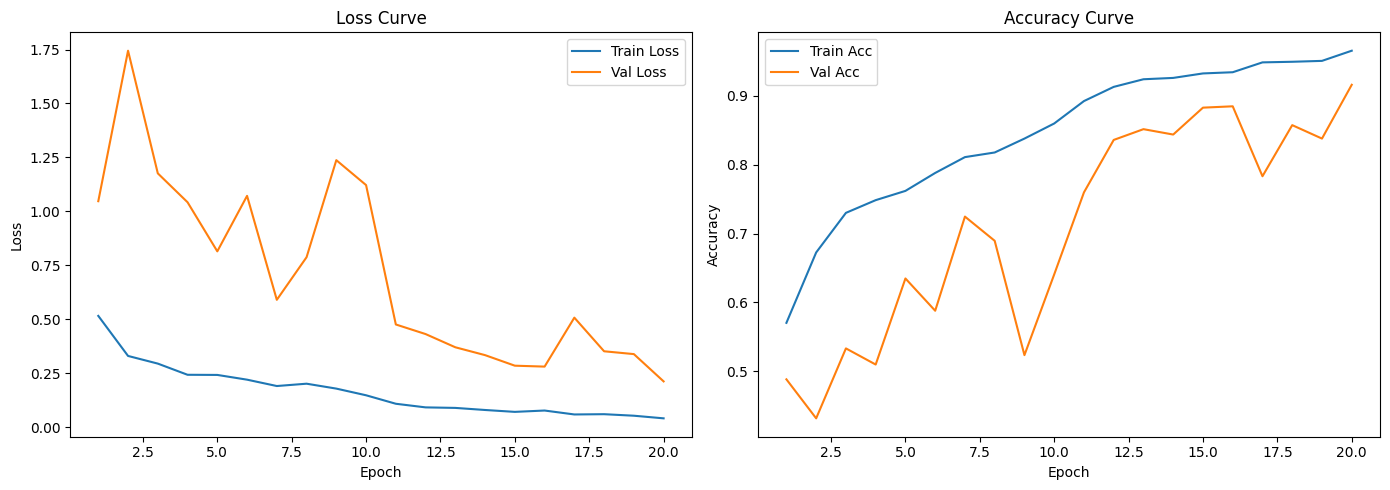

In [49]:
import matplotlib.pyplot as plt

train_loss = history['train_loss']
val_loss   = history['val_loss']
train_acc  = history['train_acc']
val_acc    = history['val_acc']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


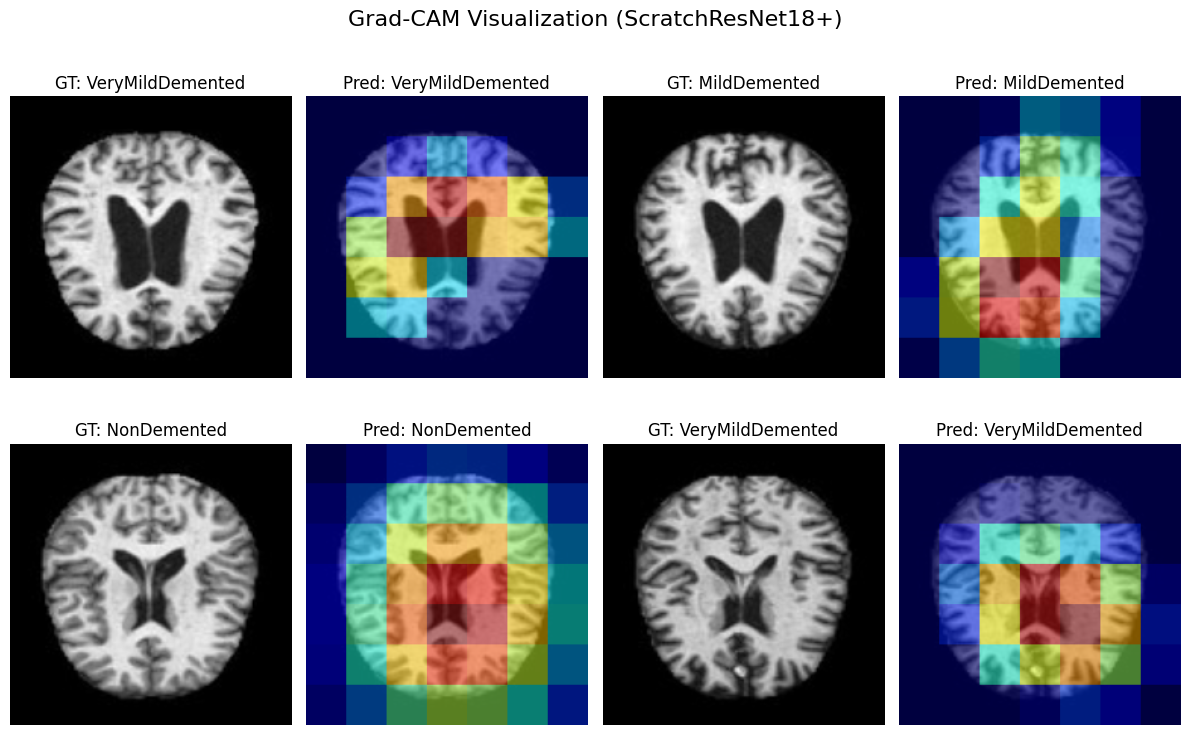

In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.transforms.functional import to_pil_image

target_layer = model.layer4[-1].conv2

def generate_gradcam(model, img_tensor):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    fwd = target_layer.register_forward_hook(forward_hook)
    bwd = target_layer.register_backward_hook(backward_hook)

    img_tensor = img_tensor.unsqueeze(0).to(device)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    fwd.remove()
    bwd.remove()

    grad = gradients[0]
    act  = activations[0]

    weights = grad.mean(dim=(2,3), keepdim=True)

    cam = (weights * act).sum(dim=1)
    cam = F.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam, pred_class


def overlay_gradcam(img_tensor, cam):
    img = img_tensor.cpu().detach()
    img = (img * 0.5 + 0.5).clamp(0,1)

    img_np = np.transpose(img.numpy(), (1,2,0))

    cam_resized = np.repeat(np.repeat(cam, 224//cam.shape[0], axis=0), 224//cam.shape[1], axis=1)
    cam_resized = cam_resized[:224, :224]

    heatmap = plt.cm.jet(cam_resized)[:, :, :3]

    overlay = 0.5 * img_np + 0.5 * heatmap
    return overlay


model.eval()
batch = next(iter(test_loader))
imgs, labels = batch

plt.figure(figsize=(12,8))
for i in range(4):
    img_tensor = imgs[i]
    cam, pred = generate_gradcam(model, img_tensor)
    overlay = overlay_gradcam(img_tensor, cam)

    plt.subplot(2,4,2*i+1)
    plt.imshow((img_tensor*0.5+0.5).permute(1,2,0))
    plt.title(f"GT: {label_names[labels[i].item()]}")
    plt.axis('off')

    plt.subplot(2,4,2*i+2)
    plt.imshow(overlay)
    plt.title(f"Pred: {label_names[pred]}")
    plt.axis('off')

plt.suptitle("Grad-CAM Visualization (ScratchResNet18+)", fontsize=16)
plt.tight_layout()
plt.show()

In [51]:
labels_arr = []
preds_arr = []

model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, pred = torch.max(outputs, 1)

        labels_arr.extend(lbls.cpu().numpy())
        preds_arr.extend(pred.cpu().numpy())

labels_arr = np.array(labels_arr)
preds_arr  = np.array(preds_arr)

print("labels_arr:", labels_arr.shape)
print("preds_arr:", preds_arr.shape)

labels_arr: (1280,)
preds_arr: (1280,)


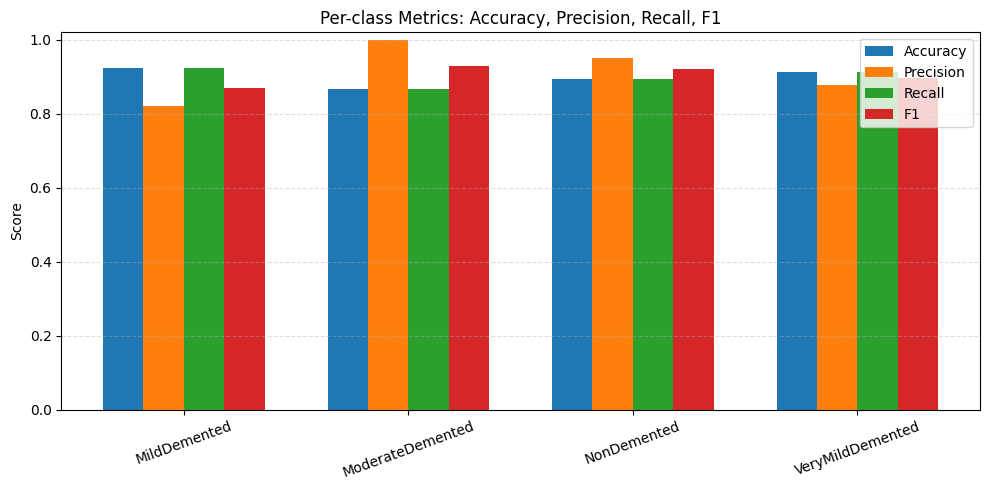

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

n_classes = len(label_names)

prec, rec, f1, sup = precision_recall_fscore_support(
    labels_arr, preds_arr,
    labels=list(range(n_classes)),
    zero_division=0
)

acc = []
for c in range(n_classes):
    mask = (labels_arr == c)
    if mask.sum() == 0:
        acc.append(0.0)
    else:
        acc.append(accuracy_score(labels_arr[mask], preds_arr[mask]))

prec = np.array(prec)
rec  = np.array(rec)
f1   = np.array(f1)
acc  = np.array(acc)

metrics = np.vstack([acc, prec, rec, f1])
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

x = np.arange(n_classes)
width = 0.18

plt.figure(figsize=(10,5))
for i in range(metrics.shape[0]):
    plt.bar(
        x + (i - 1.5) * width,
        metrics[i],
        width=width,
        label=metric_names[i]
    )

plt.xticks(x, [label_names[i] for i in range(n_classes)], rotation=20)
plt.ylim(0, 1.02)
plt.ylabel('Score')
plt.title('Per-class Metrics: Accuracy, Precision, Recall, F1')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

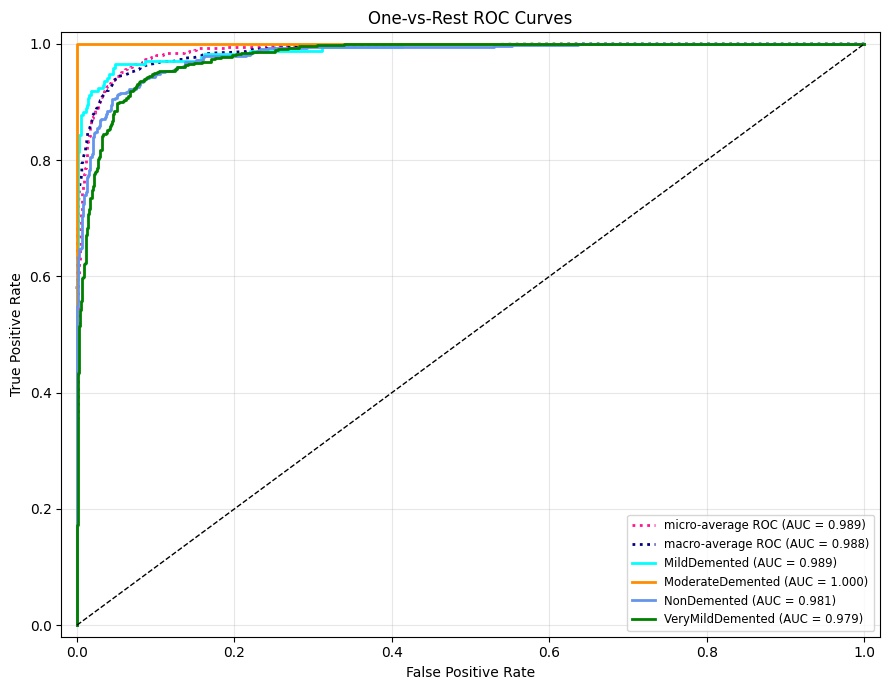

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import torch
import torch.nn.functional as F

model.eval()
probs_all = []
labels_all = []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_all.append(probs)
        labels_all.extend(labs.numpy().tolist())

probs_all = np.vstack(probs_all)
y_true = np.array(labels_all)
n_classes = len(label_names)

y_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(9,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC (AUC = {0:0.3f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC (AUC = {0:0.3f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{label_names[i]} (AUC = {roc_auc[i]:0.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-Rest ROC Curves')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Extracted features shape: (1280, 512) Targets shape: (1280,)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


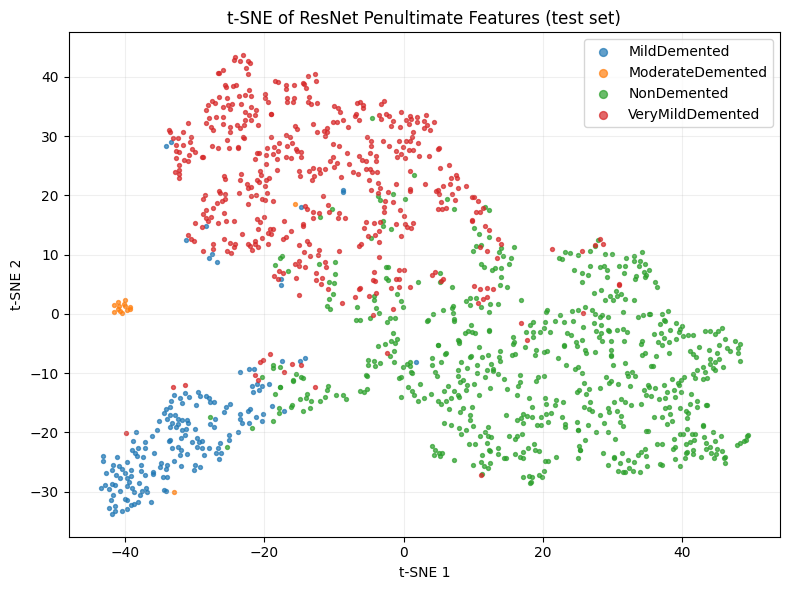

In [54]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

model.eval()
features = []
targets = []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        x = model.conv1(imgs)
        x = model.bn1(x)
        x = model.relu(x) if hasattr(model, 'relu') else torch.relu(x)
        x = model.maxpool(x) if hasattr(model, 'maxpool') else x

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)

        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        features.append(x.cpu().numpy())
        targets.extend(labs.numpy())

features = np.vstack(features)
targets = np.array(targets)

print("Extracted features shape:", features.shape, "Targets shape:", targets.shape)

max_points = 2000
if features.shape[0] > max_points:
    idx = np.random.choice(features.shape[0], max_points, replace=False)
    feat_sample = features[idx]
    lab_sample = targets[idx]
else:
    feat_sample = features
    lab_sample = targets

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca')
emb = tsne.fit_transform(feat_sample)

plt.figure(figsize=(8,6))
palette = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
for i, cname in enumerate([label_names[k] for k in range(n_classes)]):
    mask = lab_sample == i
    plt.scatter(emb[mask,0], emb[mask,1], s=8, alpha=0.7, label=cname, c=palette[i])

plt.legend(markerscale=2)
plt.title("t-SNE of ResNet Penultimate Features (test set)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [55]:
import torchvision.transforms as T
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import torch
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

pretrained_train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(0.1,0.1,0.05,0.01),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

pretrained_val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

train_ds_pre = HFDatasetTorch(train_hf, transform=pretrained_train_transforms)
val_ds_pre   = HFDatasetTorch(val_hf,   transform=pretrained_val_transforms)
test_ds_pre  = HFDatasetTorch(test_hf,  transform=pretrained_val_transforms)

train_labels = train_hf['label']
class_counts = Counter(train_labels)
num_classes = len(label_names)
total = len(train_labels)

orig_weights = [ total/(num_classes * class_counts[c]) for c in range(num_classes) ]
sqrt_weights = [ (w**0.5) for w in orig_weights ]
sample_weights = [ sqrt_weights[int(l)] for l in train_labels ]

sampler_pre = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader_pre = DataLoader(train_ds_pre, batch_size=BATCH_SIZE, sampler=sampler_pre, num_workers=NUM_WORKERS)
val_loader_pre   = DataLoader(val_ds_pre,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader_pre  = DataLoader(test_ds_pre,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Pretrained dataloaders created")
print("Train size:", len(train_ds_pre), " Val size:", len(val_ds_pre), " Test size:", len(test_ds_pre))
batch = next(iter(train_loader_pre))
print("Sample batch shapes:", batch[0].shape, batch[1].shape)

Pretrained dataloaders created
Train size: 4608  Val size: 512  Test size: 1280
Sample batch shapes: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [56]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import copy
import torch

def get_prebuilt_model(name='resnet18', pretrained=True, num_classes=4, freeze_backbone=False):
    name = name.lower()
    if name == 'resnet18':
        try:
            model = models.resnet18(pretrained=pretrained)
        except Exception:
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if hasattr(models, 'ResNet18_Weights') else None)
        # replace fc
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
    elif name == 'densenet121':
        try:
            model = models.densenet121(pretrained=pretrained)
        except Exception:
            model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT if hasattr(models, 'DenseNet121_Weights') else None)
        in_f = model.classifier.in_features
        model.classifier = nn.Linear(in_f, num_classes)
    elif name == 'mobilenet_v2':
        try:
            model = models.mobilenet_v2(pretrained=pretrained)
        except Exception:
            model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if hasattr(models, 'MobileNet_V2_Weights') else None)
        in_f = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_f, num_classes)
    else:
        raise ValueError("Model not supported")

    if freeze_backbone:
        for name_p, p in model.named_parameters():
            if 'fc' not in name_p and 'classifier' not in name_p:
                p.requires_grad = False
    return model

In [57]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [58]:
models_to_run = {
    'resnet18_pretrained': {'name':'resnet18','pretrained':True, 'freeze_backbone': True},
    'densenet121_pretrained': {'name':'densenet121','pretrained':True, 'freeze_backbone': True},
}


FINETUNE = True
EPOCHS_FINETUNE = 6
LR = 1e-4

model_checkpoints = {}
model_histories = {}

for label, cfg in models_to_run.items():
    print("\n=== Preparing model:", label, cfg)
    m = get_prebuilt_model(cfg['name'], pretrained=cfg['pretrained'], num_classes=len(label_names), freeze_backbone=cfg['freeze_backbone'])
    m = m.to(device)

    try:
        cw_tensor
    except NameError:
        cw_tensor = torch.tensor([1.0]*len(label_names), dtype=torch.float32).to(device)
    criterion_pt = nn.CrossEntropyLoss(weight=cw_tensor)

    params = [p for p in m.parameters() if p.requires_grad]
    optimizer_pt = optim.Adam(params, lr=LR)
    scheduler_pt = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pt, mode='min', factor=0.5, patience=2)


    global_train_loader_backup = globals().get('train_loader', None)
    global_val_loader_backup   = globals().get('val_loader', None)

    globals()['train_loader'] = train_loader_pre
    globals()['val_loader']   = val_loader_pre

    if FINETUNE:
        print("Finetuning", label, "for", EPOCHS_FINETUNE, "epochs ...")
        m, history = train_model(m, criterion_pt, optimizer_pt, scheduler_pt, EPOCHS_FINETUNE)
        model_histories[label] = history
        ckpt = f"{label}_finetuned.pth"
        torch.save(m.state_dict(), ckpt)
        model_checkpoints[label] = ckpt
        print("Saved checkpoint to", ckpt)
    else:
        ckpt = f"{label}_init.pth"
        torch.save(m.state_dict(), ckpt)
        model_checkpoints[label] = ckpt
        print("Saved initial checkpoint to", ckpt)

    if global_train_loader_backup is not None:
        globals()['train_loader'] = global_train_loader_backup
    else:
        globals().pop('train_loader', None)
    if global_val_loader_backup is not None:
        globals()['val_loader'] = global_val_loader_backup
    else:
        globals().pop('val_loader', None)

    globals()[f"model_{label}"] = m

print("\nAll requested models are prepared. If FINETUNE=False then models are ready for evaluation.")


=== Preparing model: resnet18_pretrained {'name': 'resnet18', 'pretrained': True, 'freeze_backbone': True}


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finetuning resnet18_pretrained for 6 epochs ...
Epoch 1/6
  train Loss: 1.4244 Acc: 0.2869
  val Loss: 1.3511 Acc: 0.3770
Epoch time: 23.1s

Epoch 2/6
  train Loss: 1.3363 Acc: 0.3646
  val Loss: 1.3112 Acc: 0.3945
Epoch time: 22.8s

Epoch 3/6
  train Loss: 1.2781 Acc: 0.4247
  val Loss: 1.3000 Acc: 0.4102
Epoch time: 21.7s

Epoch 4/6
  train Loss: 1.2480 Acc: 0.4212
  val Loss: 1.2281 Acc: 0.4648
Epoch time: 23.3s

Epoch 5/6
  train Loss: 1.2183 Acc: 0.4401
  val Loss: 1.2269 Acc: 0.4609
Epoch time: 22.7s

Epoch 6/6
  train Loss: 1.1913 Acc: 0.4542
  val Loss: 1.1776 Acc: 0.5098
Epoch time: 23.0s

Best val Acc: 0.5098
Saved checkpoint to resnet18_pretrained_finetuned.pth

=== Preparing model: densenet121_pretrained {'name': 'densenet121', 'pretrained': True, 'freeze_backbone': True}
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 180MB/s]


Finetuning densenet121_pretrained for 6 epochs ...
Epoch 1/6
  train Loss: 1.3787 Acc: 0.3047
  val Loss: 1.3341 Acc: 0.4062
Epoch time: 26.3s

Epoch 2/6
  train Loss: 1.3040 Acc: 0.4208
  val Loss: 1.2973 Acc: 0.4316
Epoch time: 26.6s

Epoch 3/6
  train Loss: 1.2644 Acc: 0.4366
  val Loss: 1.2673 Acc: 0.4316
Epoch time: 26.2s

Epoch 4/6
  train Loss: 1.2120 Acc: 0.4813
  val Loss: 1.2232 Acc: 0.4824
Epoch time: 26.2s

Epoch 5/6
  train Loss: 1.1836 Acc: 0.4852
  val Loss: 1.1880 Acc: 0.5020
Epoch time: 26.2s

Epoch 6/6
  train Loss: 1.1550 Acc: 0.5104
  val Loss: 1.2021 Acc: 0.4863
Epoch time: 26.5s

Best val Acc: 0.5020
Saved checkpoint to densenet121_pretrained_finetuned.pth

All requested models are prepared. If FINETUNE=False then models are ready for evaluation.


Models to evaluate: ['resnet18_pretrained', 'densenet121_pretrained']

Evaluating resnet18_pretrained ...
 Test acc for resnet18_pretrained: 0.4914
                  precision    recall  f1-score   support

    MildDemented       0.24      0.45      0.31       172
ModerateDemented       0.05      0.27      0.09        15
     NonDemented       0.66      0.69      0.67       634
VeryMildDemented       0.50      0.24      0.32       459

        accuracy                           0.49      1280
       macro avg       0.36      0.41      0.35      1280
    weighted avg       0.54      0.49      0.49      1280


Evaluating densenet121_pretrained ...
 Test acc for densenet121_pretrained: 0.4859
                  precision    recall  f1-score   support

    MildDemented       0.28      0.40      0.33       172
ModerateDemented       0.09      0.67      0.16        15
     NonDemented       0.65      0.64      0.65       634
VeryMildDemented       0.46      0.31      0.37       459

        a

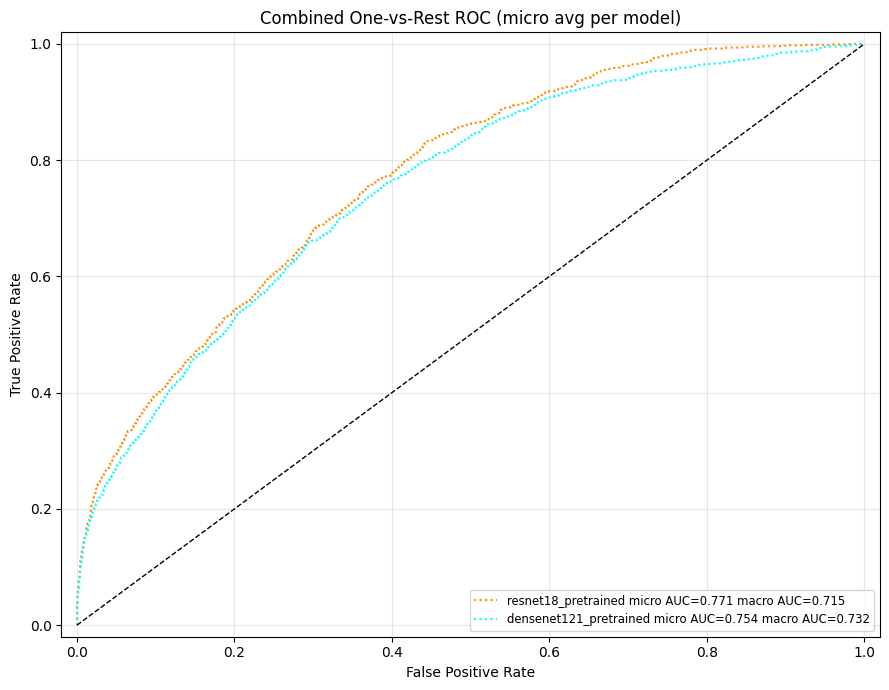

In [59]:
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import itertools

available_models = {
    'resnet18_pretrained': globals().get('model_resnet18_pretrained'),
    'densenet121_pretrained': globals().get('model_densenet121_pretrained')
}
available_models = {k:v for k,v in available_models.items() if v is not None}
print("Models to evaluate:", list(available_models.keys()))

results = {}
for name, m in available_models.items():
    print(f"\nEvaluating {name} ...")
    m.eval()
    probs_list = []
    y_true = []
    with torch.no_grad():
        for imgs, labs in test_loader_pre:
            imgs = imgs.to(device)
            out = m(imgs)
            probs = F.softmax(out, dim=1).cpu().numpy()
            probs_list.append(probs)
            y_true.extend(labs.cpu().numpy().tolist())
    probs_all = np.vstack(probs_list)    # (N, C)
    y_true = np.array(y_true)
    preds = np.argmax(probs_all, axis=1)

    results[name] = {
        'probs': probs_all,
        'y_true': y_true,
        'preds': preds
    }
    acc = (preds == y_true).mean()
    print(f" Test acc for {name}: {acc:.4f}")
    print(classification_report(y_true, preds, target_names=[label_names[i] for i in range(len(label_names))], zero_division=0))

plt.figure(figsize=(9,7))
colors = ['darkorange','aqua','green','purple','navy','red']
for (i, (name, res)), color in zip(enumerate(results.items()), itertools.cycle(colors)):
    probs_all = res['probs']
    y_true = res['y_true']
    n_classes = probs_all.shape[1]
    y_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict(); tpr = dict(); roc_auc = dict()
    for c in range(n_classes):
        fpr[c], tpr[c], _ = roc_curve(y_bin[:,c], probs_all[:,c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), probs_all.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)

    all_fpr = np.unique(np.concatenate([fpr[c] for c in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for c in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= n_classes
    auc_macro = auc(all_fpr, mean_tpr)

    plt.plot(fpr_micro, tpr_micro, linestyle=':', color=color,
             label=f"{name} micro AUC={auc_micro:.3f} macro AUC={auc_macro:.3f}")

plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlim([-0.02,1.02]); plt.ylim([-0.02,1.02])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Combined One-vs-Rest ROC (micro avg per model)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

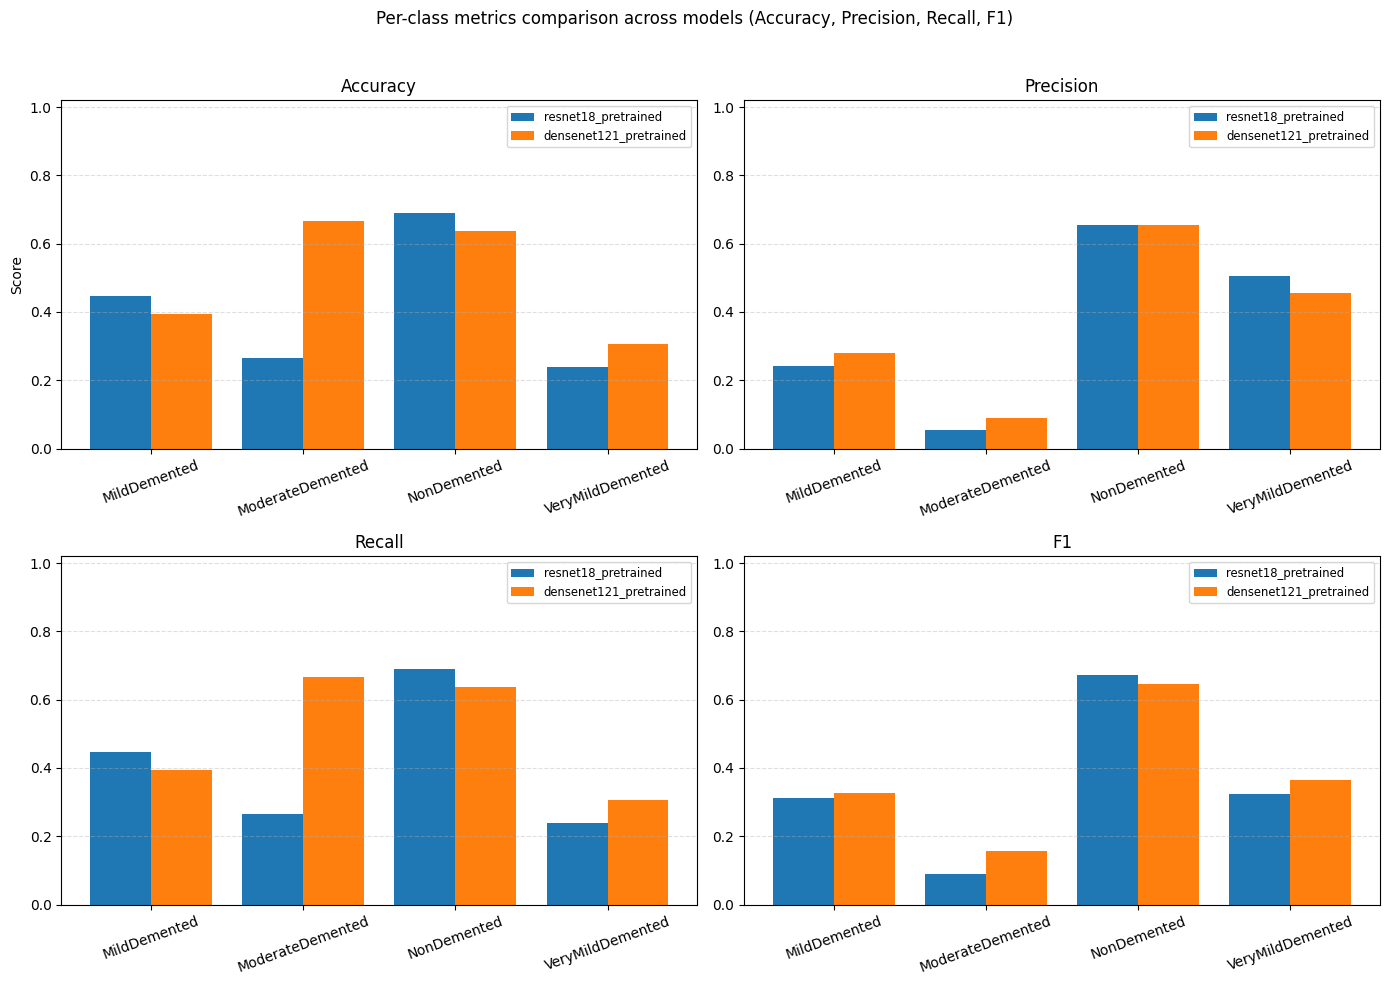

In [60]:
model_names = list(results.keys())
n_models = len(model_names)
n_classes = len(label_names)

metrics_names = ['Accuracy','Precision','Recall','F1']
metrics = np.zeros((4, n_models, n_classes))

for mi, mname in enumerate(model_names):
    y_true = results[mname]['y_true']
    preds  = results[mname]['preds']
    prec, rec, f1, sup = precision_recall_fscore_support(y_true, preds, labels=list(range(n_classes)), zero_division=0)
    acc_per = []
    for c in range(n_classes):
        mask = (y_true == c)
        if mask.sum() == 0:
            acc_per.append(0.0)
        else:
            acc_per.append(accuracy_score(y_true[mask], preds[mask]))
    metrics[0, mi, :] = acc_per
    metrics[1, mi, :] = prec
    metrics[2, mi, :] = rec
    metrics[3, mi, :] = f1

fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
x = np.arange(n_classes)
width = 0.8 / n_models

for idx, ax in enumerate(axes):
    for j, mname in enumerate(model_names):
        ax.bar(x + (j - (n_models-1)/2)*width, metrics[idx, j, :], width=width, label=mname)
    ax.set_title(metrics_names[idx])
    ax.set_xticks(x)
    ax.set_xticklabels([label_names[i] for i in range(n_classes)], rotation=20)
    ax.set_ylim(0,1.02)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    if idx == 0:
        ax.set_ylabel('Score')
    ax.legend(fontsize='small')

plt.suptitle("Per-class metrics comparison across models (Accuracy, Precision, Recall, F1)")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()